<a href="https://colab.research.google.com/github/aaolcay/Traditional-Machine-Learning-Techniques/blob/main/Multilayer_perceptron_vs_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Logistic Regression vs Multilayer Preceptron**

In this notebook, we introduce the importance of non-linear activation functions as well as using multilayer in the neural network. The content and data are based on one of the most popular courses available on Coursera: [NNsDL](https://www.coursera.org/learn/neural-networks-deep-learning). It is highly recommended to take this course as the instructors are highly experienced in both machine and deep learning, and it also allows you to become part of the [DeepLearning AI community](https://www.deeplearning.ai/). However, the focus of this notebook is to provide clarity on the capabilities and limitations of logistic regression in classification tasks and to demonstrate how non-linearity can enhance the accuracy of the model in classification.

####**Load Dataset**
The dataset includes couple of locations in x-y coordinates, and they are assigned (labelled) to red(0) and blue(1) colors (see: Figure 1)

In [107]:
# Load Dataset
import numpy as np

np.random.seed(1)
m = 400 # number of examples
N = int(m/2) # number of points per class
D = 2 # dimensionality
X = np.zeros((m,D)) # data matrix where each row is a single example
Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
a = 4 # maximum ray of the flower

for j in range(2):
  ix = range(N*j,N*(j+1))
  t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
  r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  Y[ix] = j

X = X.T
Y = Y.T

In [108]:
print(f"The shape of training dataset: {X.shape}")
print(f"The shape of label vector: {Y.shape}")
print(f"Number of examples in each feature: {X.shape[1]}")

The shape of training dataset: (2, 400)
The shape of label vector: (1, 400)
Number of examples in each feature: 400


#####**Plot Data**
Please do not forget importing `matplotlib`, by which we will show how data is distributed with their colors.

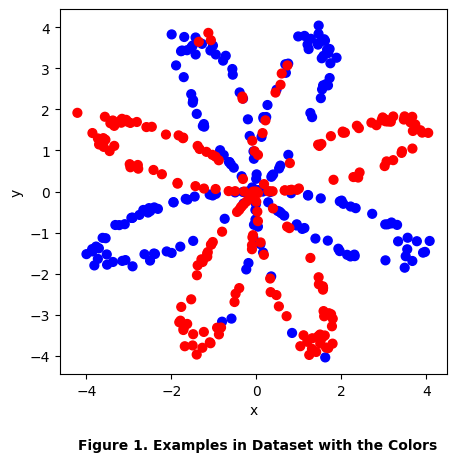

In [109]:
# To avoid any text output appearing above the figures
%matplotlib inline 
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap='bwr')
plt.subplots_adjust(bottom=0.15)  # add padding to the bottom
plt.xlabel('x')
plt.ylabel('y')
plt.figtext(.52, .0000002, "Figure 1. Examples in Dataset with the Colors", ha='center',fontsize=10, fontweight='bold')
plt.show() # added to force the figure to display

####**Simple Logistic Regression**
In order to implement logistic regression, we exploit from `sklearn.linear_model.LogisticRegression` a ready library in Python. As depicted, logistic regression is a linear classifier and do prediction according to the linear associations in the data. Nevertheless, as seen in Figure 1, the data points are not linearly correlated.

To perform logistic regression with k-fold cross-validation built-in, we use `sklearn.linear_model.LogisticRegressionCV`.

In [110]:
from sklearn.linear_model import LogisticRegressionCV
# Train the logistic regression classifier
lrCV = LogisticRegressionCV(cv=5)
lrCV.fit(X.T, Y.ravel().T)

LogisticRegressionCV(cv=5)

In [111]:
def plot_decision_boundary(model, X, y):
    plt.figure(figsize=(5,5))
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap="bwr")
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap="bwr")

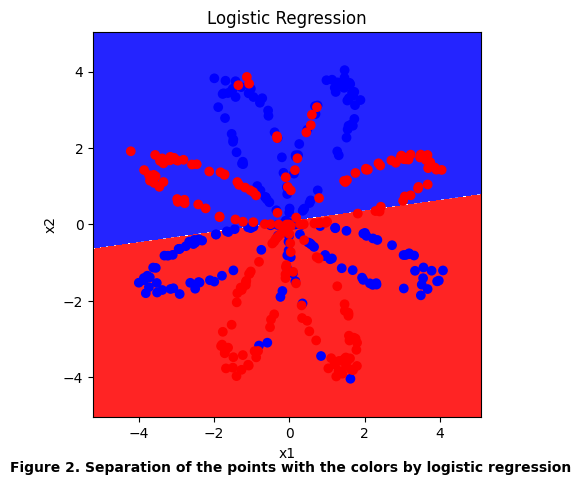

In [112]:
plot_decision_boundary(lambda x: lrCV.predict(x), X, Y)
plt.title("Logistic Regression")
plt.figtext(.52, .0000002, "Figure 2. Separation of the points with the colors by logistic regression", ha='center',fontsize=10, fontweight='bold')
plt.show()

In [113]:
predictions = lrCV.predict(X.T)
predictions = predictions.reshape(-1,1).T # (1, 400)
#accuracy = (predictions-Y)

In [114]:
diffs = []
for i in range(predictions.shape[1]):
  difference = predictions[:,i].astype('float')-Y[:,i].astype('float')
  diffs.append(difference)

diffs = np.asarray(diffs)
true_pred = np.where(diffs==0)
true_pred = np.asarray(true_pred)[0]
accuracy = len(true_pred)/len(diffs)
print(f"Accuracy of Logistic Regression is: {accuracy*100}%")

Accuracy of Logistic Regression is: 47.0%


Based on the results shown in Figure 2, where an accuracy of 47% was achieved, it appears that logistic regression is not very effective for classifying this non-linearly correlated data. This is due to a significant number of blue points being misclassified as red, and vice versa (as evident from the logistic regression model's predictions for blue and red regions). Hence, in the next section, we will use a non-linear activation function with a hidden layer to improve the classification accuracy.

####**Neural Network Model**
The same notations are used as that in [NNsDL](https://www.coursera.org/learn/neural-networks-deep-learning). Neural Network architecture consists of:
- 2 input features (red and blue)
- 1 hidden layer with 4 neurons (neurons have tanh, hyperbolic tangent, activation functions)
- Output layer with sigmoid function

The Neural Network model built works in three steps:

**1) Forward Propagation**:

Forward propagation is the process of moving input data through a neural network to generate a prediction. It starts by feeding the input data into the first layer of the network and then applying a series of mathematical transformations to the data as it moves through each subsequent layer, ultimately producing an output or prediction. These transformations are typically defined by a set of weights and biases that are learned during the training process. The output or prediction generated by the network is then compared to the actual target value to compute a loss, which is used to update the weights and biases during training.

**1.1) Forward Propagation Mathematical Notations**:

In order to calculate the cost function, the forward propagation steps are shown mathematically as following.

$$Z^{[1]} = W^{[1]} X + b^{[1]} \tag{1}$$

$$A^{[1]} = \tanh(Z^{[1]}) \tag{2}$$

$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]} \tag{3}$$

$$A^{[2]} = \sigma(Z^{[2]}) \tag{4}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows:

$$J = -\frac{1}{m}\sum_{i=1}^{m} \left(y^{(i)}\log(A^{[2](i)}) + (1-y^{(i)})\log(1-A^{[2](i)})\right) \tag{5}$$

**2) Backpropagation**:

The most challenging aspect of deep learning typically involves backpropagation, which involves a significant amount of mathematical complexity. Backpropagation is a supervised learning algorithm used in artificial neural networks to adjust the weights of connections between neurons, by propagating errors from the output layer back through the network.

**2.1) Mathematical Procedure of Backpropagation**:

We introduce the math behind the backpropagation as notational. Note that the equations given are of vectorized parameters.

$$dZ^{[2]} = A^{[2]} - Y \tag{6}$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T} \tag{7}$$
$$db^{[2]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[2](i)} \tag{8}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} \odot (1 - \tanh^2(Z^{[1]})) \tag{9}$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} X^T \tag{10}$$
$$db^{[1]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[1](i)} \tag{11}$$

**3) Prediction**:

If the predicted output is larger than a threshold (e.g., 0.5) we say this is blue (1) and otherwise the sample is red (0) color.

$$\hat{y} = \begin{cases} \text{blue (1)} & \mbox{if } A^{[2]} > 0.5 \\ \text{red (0)} & \mbox{otherwise} \end{cases}\tag{12}$$



#####**1) Forward Propagation**

In [115]:
def forward_propagation(X, Y, params): # from (1) to (5)
  """ 
    params -- python dictionary consisting of parameters:
    W1 -- weight matrix of shape (n_h, features)
    b1 -- bias vector of shape (n_h, 1)
    W2 -- weight matrix of shape (n_output, n_h)
    b2 -- bias vector of shape (n_output, 1)
     X -- train data (features, m)
     Y -- label/target data(1, m)
    Z1 -- linear regression calculation in the first hidden layer (n_h, m)
    A1 -- tanh activation function (first hidden layer) (n_h, m)
    Z2 -- linear regression calculation in the output layer (n_output, m)
    A2 -- sigmoid activation function (output layer) (n_output, m)
     m -- Number of examples
  """
  # Retrieve each parameter
  W1 = params["W1"]
  b1 = params["b1"]
  W2 = params["W2"]
  b2 = params["b2"]
  #------------------------------------------------------------------------#
  # Equations from (1) to (4):
  Z1 = np.dot(W1,X) + b1
  A1 = np.tanh(Z1) # activation function of hidden layer: hyperbolic tangent
  Z2 = np.dot(W2,A1) + b2
  A2 = 1/(1+np.exp(-Z2)) # sigmoid function
  #------------------------------------------------------------------------#
  forward =  {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
  #------------------------------------------------------------------------#
  # Compute Cost (equation (5))
  log_loss = np.multiply(np.log(A2),Y) + np.multiply((np.log(1-A2)),(1-Y))
  cost = -(1/m)*np.sum(log_loss)

  return A2, forward, cost

#####**2) Backpropagation**

In [116]:
def backpropagation(params, forward, X, Y, learning_rate):
  #------------------------------------------------------------------------#
  m = X.shape[1] # Number of examples
  W1 = params["W1"]
  b1 = params["b1"]
  W2 = params["W2"]
  b2 = params["b2"]
  A1 = forward["A1"]
  A2 = forward["A2"]
  #------------------------------------------------------------------------#
  # Backpropagation: Equations from (6) to (11)
  dZ2 = A2 - Y
  dW2 = (1/m)*np.dot(dZ2,A1.T)
  db2 = (1/m)*np.sum(dZ2, axis=1, keepdims=True)
  dZ1 = np.dot(W2.T,dZ2)*(1 - np.power(A1, 2))
  dW1 = (1/m)*np.dot(dZ1,X.T)
  db1 = (1/m)*np.sum(dZ1, axis=1, keepdims=True)
  #------------------------------------------------------------------------#
  # Update parameters
  W1 = W1 - learning_rate*dW1
  b1 = b1 - learning_rate*db1
  W2 = W2 - learning_rate*dW2
  b2 = b2 - learning_rate*db2
  params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
  return params

#####**3) Neural Network**

In [117]:
def neural_network(X, Y, n_h, num_iterations, learning_rate = 0.1, print_cost=False):
  #------------------------------------------------------------------------#
  """
    - n_h: Number of neurons in the hidden layer
    - X: Train dataset
    - Y: Target/Labels
    - num_iterations: Number of iterations for forward/backpropagations 
    :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
    examples = 100;
    batch_size = 2;
    iterations in each epoch = examples/batch_size -> 50
    :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
  """
  #------------------------------------------------------------------------#
  features = X.shape[0] # Number of features (blue,red) -> 2
  n_output = Y.shape[0] # Number of neurons in the output layer -> 1
  #------------------------------------------------------------------------#
  # Initialize parameters:
  W1 = np.random.randn(n_h,features)*0.01
  b1 = np.zeros((n_h,1))
  W2 = np.random.randn(n_output,n_h)*0.01
  b2 = np.zeros((n_output,1))
  params =  {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
  # Gradient Descent
  history_cost = []
  for i in range(num_iterations):
    A2, forward, cost = forward_propagation(X, Y, params)
    params = backpropagation(params, forward, X, Y, learning_rate)
    if print_cost and i % 1000 == 0:
      print ("Cost after iteration %i: %f" %(i, cost))
    history_cost.append(cost)

  return params, np.asarray(history_cost)

#####**4) Predict**

In [118]:
def predict(params, X, Y):
  A2, forward, cost = forward_propagation(X, Y, params)
  predictions = A2>0.5
  return predictions

In [119]:
# Build a model with a n_h-dimensional hidden layer
params, history_cost = neural_network(X, Y, n_h = 4, num_iterations = 100000, learning_rate =1.2, print_cost=True)

Cost after iteration 0: 0.693113
Cost after iteration 1000: 0.282578
Cost after iteration 2000: 0.269777
Cost after iteration 3000: 0.262318
Cost after iteration 4000: 0.241228
Cost after iteration 5000: 0.226023
Cost after iteration 6000: 0.221621
Cost after iteration 7000: 0.218907
Cost after iteration 8000: 0.216885
Cost after iteration 9000: 0.215260
Cost after iteration 10000: 0.218025
Cost after iteration 11000: 0.217501
Cost after iteration 12000: 0.216984
Cost after iteration 13000: 0.216512
Cost after iteration 14000: 0.216089
Cost after iteration 15000: 0.215710
Cost after iteration 16000: 0.215368
Cost after iteration 17000: 0.215057
Cost after iteration 18000: 0.214773
Cost after iteration 19000: 0.214510
Cost after iteration 20000: 0.214268
Cost after iteration 21000: 0.214042
Cost after iteration 22000: 0.213831
Cost after iteration 23000: 0.213633
Cost after iteration 24000: 0.213447
Cost after iteration 25000: 0.213271
Cost after iteration 26000: 0.213105
Cost after ite

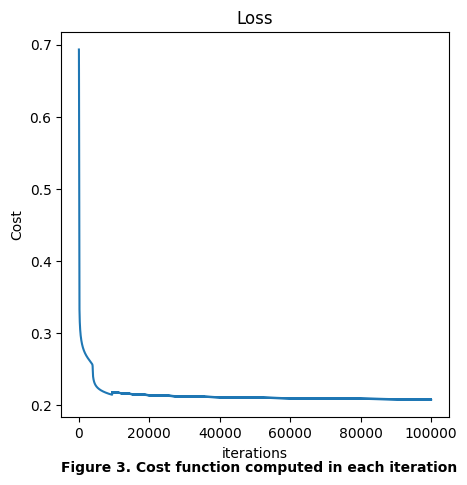

In [120]:
plt.figure(figsize=(5,5))
iter = np.arange(0,100000,1)
plt.plot(iter,history_cost)
plt.xlabel("iterations")
plt.ylabel("Cost")
plt.title("Loss")
plt.figtext(.52, .0000002, "Figure 3. Cost function computed in each iteration", ha='center',fontsize=10, fontweight='bold')
plt.show()

In [121]:
predictions = predict(params, X, Y)

In [122]:
diffs = []
for i in range(predictions.shape[1]):
  difference = predictions[:,i].astype('float')-Y[:,i].astype('float')
  diffs.append(difference)

diffs = np.asarray(diffs)
true_pred = np.where(diffs==0)
true_pred = np.asarray(true_pred)[0]
accuracy = len(true_pred)/len(diffs)
print(f"Accuracy of Neural Network is: {accuracy*100}%")

Accuracy of Neural Network is: 91.5%
